# Homework 2 - Generalized Hough Transform

# Theory

## Task 1
### The 2nd answer is correct, because the displacement is rotated 90 degrees, which means the displacement vectors (x, y) become (-y, x) and all rows have to be shifted circularly 2 rows down. 

## Task 2
![title](Ex2-theory.jpeg)

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window

    Returns
    -------
    result : ndarray

    """

    rows, cols = img.shape
    result = np.zeros((rows, cols))

    # iterate over pixels
    # iterate over (2d+1,2d+1) neighborhood window
    for row in range(rows):
        for col in range(cols):
            left, right = max(0, col - d), min(cols - 1, col + d + 1)
            top, bottom = max(0, row - d), min(rows - 1, row + d + 1)

            # supress non-maxima to 0
            # store results in new array
            m = np.max(img[top:bottom, left:right])
            result[row, col] = m if img[row, col] == m else 0

    return result


def calcBinaryMask(img, thresh=0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    # -compute gradients
    abs_gradient = np.abs(utils.calcDirectionalGrad(img))

    # -threshold gradients
    result = np.where(abs_gradient > thresh *
                      np.max(abs_gradient), 1.0, abs_gradient)

    # -return binary mask
    return result


def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.

    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.

    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """

    rows, cols = template.shape

    def extend_img(img, new_shape):
        tmp = np.zeros(shape=new_shape, dtype=type(img))
        tmp[:rows, :cols] = img
        return tmp

    # -dft of the image, already computed in GeneralizedHoughTransform(...)
    DFT_I = img

    # -compute gradient of the template
    Oi = utils.calcDirectionalGrad(template)

    # -copy template gradient into larger frame
    Oi = extend_img(Oi, new_shape=img.shape)
    Ob = extend_img(calcBinaryMask(template, 0.75), new_shape=img.shape)

    # -apply a circular shift so the center of the original template is in the
    # upper left corner
    Oi = utils.circularShift(Oi, cols // 2, rows // 2)
    Ob = utils.circularShift(Ob, cols // 2, rows // 2)

    # -normalize template
    Oi /= np.sum(np.abs(Oi))

    T = Oi * Ob

    # -compute correlation
    DFT_T = np.fft.fft2(T)
    I_T = np.fft.ifft2(DFT_I * np.conj(DFT_T))
    return np.abs(I_T.real)


def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.

    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.

        Note the order of these values.
    """
    import itertools

    lst = []

    DFT_I = np.fft.fft2(utils.calcDirectionalGrad(img))

    # for every combination of angles and scales
    for angle, scale in itertools.product(angles, scales):

        # -distort template
        distorted_template = utils.rotateAndScale(template, angle, scale)

        # -compute the correlation
        corr = correlation(DFT_I, distorted_template)

        # -store results with parameters in a list
        lst.append((corr, angle, scale))

    return lst


# Main Program

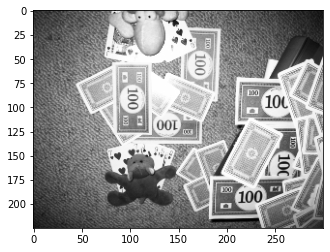

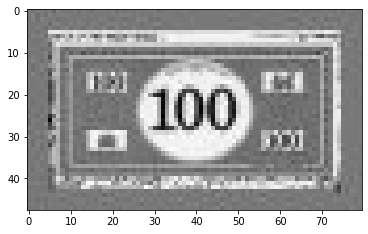

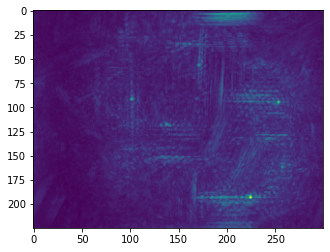

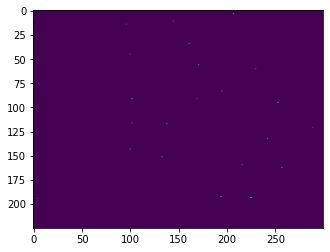

133 151
242 132
257 162
171 56
138 117
253 95
102 91
225 193
194 192
207 3


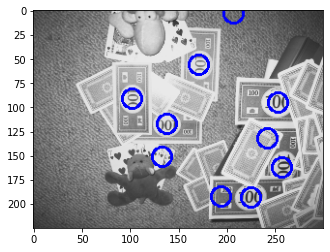

In [2]:
# Load query image and template
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(
    *np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query], 2)
for y, x in coords:
    print(x, y)
    vis = cv2.circle(vis, (x, y), 10, (255, 0, 0), 2)
utils.show(vis)


# Test your implementation

In [3]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

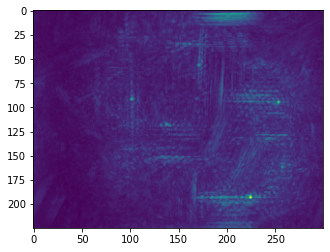

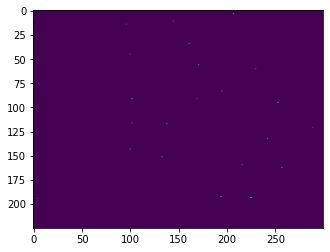

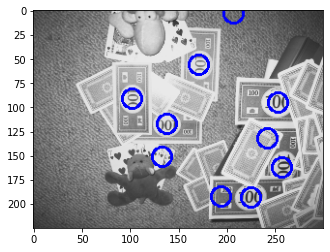

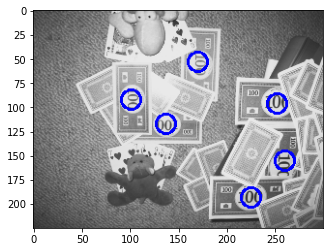

{"scores": {"Correct_Detections": 6}}


In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def testGHT():
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    

    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    #votes = correlation(query, template)
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))

    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    coords = np.array(coords)[:,::-1]

    
    d = euclidean_distances(centroids, coords).min(1)
    
    correct_detections = np.count_nonzero((d<10))
    
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()